In [1]:
import numpy as np
import pandas as pd
import vectorbt as vbt
import quantstats as qs
import matplotlib.pyplot as plt

from binance import Client
from binance.enums import HistoricalKlinesType

### 抓資料並切割樣本

In [2]:
#get binance data

client = Client()
value = client.get_historical_klines(symbol = 'BTCUSDT', 
                                      interval = '15m', 
                                      start_str = '2020-01-01', 
                                      end_str = '2023-06-30',
                                      klines_type=HistoricalKlinesType.FUTURES)

columns_name = ['openTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'closeTime', 
                'quoteVolume', 'numTrade', 'takerBuyVolume', 'takerBuyQuoteVolume', 'ignore']

df = pd.DataFrame(value)
df.columns = columns_name
df['openTime']= pd.to_datetime(df['openTime'], unit='ms')
df = df.drop(['ignore', 'closeTime'], axis=1)
df = df.sort_values('openTime', ascending=True)
df = df.set_index('openTime')
df = df.astype(float)
df = df[~df.index.duplicated(keep='first')]

In [3]:
#split to in and out sample
price_all = df[['Open', 'High', 'Low', 'Close']]
price_is = price_all['2020-01-01':'2022-08-31'] # in sample data
price_os = price_all['2022-09-01':'2023-06-30'] # out sample data
print(price_all)
print(price_is)
print(price_os)

                         Open      High       Low     Close
openTime                                                   
2020-01-01 00:00:00   7189.43   7190.52   7172.94   7176.26
2020-01-01 00:15:00   7176.22   7179.41   7170.69   7172.36
2020-01-01 00:30:00   7172.79   7179.45   7170.61   7174.83
2020-01-01 00:45:00   7174.51   7179.36   7170.15   7171.55
2020-01-01 01:00:00   7171.43   7188.77   7171.10   7186.60
...                       ...       ...       ...       ...
2023-06-29 23:00:00  30402.50  30409.00  30380.00  30395.70
2023-06-29 23:15:00  30395.70  30476.00  30383.10  30472.00
2023-06-29 23:30:00  30472.10  30523.50  30460.00  30470.00
2023-06-29 23:45:00  30469.90  30470.00  30430.40  30439.90
2023-06-30 00:00:00  30439.90  30466.80  30408.00  30408.00

[122497 rows x 4 columns]
                         Open      High       Low     Close
openTime                                                   
2020-01-01 00:00:00   7189.43   7190.52   7172.94   7176.26
2020-01-01 00

### 定義策略

In [4]:
#double rsi as signal and filter
def rsi_long(close, rsi_window = 29, filter_window = 50):

    rsi_crossover = vbt.RSI.run(close, window=rsi_window).rsi_crossed_above(70).to_numpy()
    rsi_crossunder = vbt.RSI.run(close, window=rsi_window).rsi_crossed_below(30).to_numpy()

    rsi_filter = vbt.RSI.run(close, window = filter_window).rsi.to_numpy()

    signal = np.where(rsi_crossover & (rsi_filter > 70), 1, 0)
    signal = np.where(rsi_crossunder, -1, signal)

    return signal

MyInd = vbt.IndicatorFactory(
    class_name = 'rsi_long',
    short_name = 'long',
    input_names = ['close'],
    param_names = ['rsi_window', 'filter_window'],
    output_names = ['signals'] 
).from_apply_func(rsi_long, keep_pd=True)

### 參數優化

In [9]:
#run strategy and do parameter optimization on in sample data

win = np.arange(20, 50)
signal = MyInd.run(price_is['Close'] , rsi_window=win, filter_window=win, param_product = True)

entries = signal.signals == 1
exits = signal.signals == -1

portfolio = vbt.Portfolio.from_signals(
    price_is['Close'], 
    entries, 
    exits,
    freq = '15m', 
    direction = 'longonly', 
    sl_stop = 0.03,
    fees = 0.0015
)

print(portfolio.total_return().sort_values())
print(portfolio.sharpe_ratio().sort_values())

long_rsi_window  long_filter_window
20               20                   -0.592385
21               21                   -0.528170
22               41                   -0.449519
                 42                   -0.423551
                 43                   -0.394123
                                         ...   
49               21                    4.982664
32               34                    5.034642
49               33                    5.117464
                 20                    5.157155
                 38                    5.674729
Name: total_return, Length: 900, dtype: float64
long_rsi_window  long_filter_window
22               41                   -0.805691
                 42                   -0.721886
                 43                   -0.712548
21               48                   -0.612060
                 44                   -0.562227
                                         ...   
32               34                    1.777865
33              

In [11]:
pf = pd.concat([portfolio.total_return(),  portfolio.sharpe_ratio()], axis=1)

In [12]:
# 畫出參數高原
import plotly.graph_objects as go

x = pf.loc[pf['total_return'] > 0].index.get_level_values(0)
y = pf.loc[pf['total_return'] > 0].index.get_level_values(1)
z = pf.loc[pf['total_return'] > 0]['total_return']
data = (pf.loc[pf['total_return'] > 0]['sharpe_ratio'])
scatter_data = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        color=data,  # 将第四维数据用颜色表示
        colorscale='Viridis',
        colorbar=dict(title='Sharpe')  # 添加颜色条
    )
)

# 创建图布局
layout = go.Layout(
    title='3D Scatter Plot',
    scene=dict(
        xaxis=dict(title='rsi_window'),
        yaxis=dict(title='filter_window'),
        zaxis=dict(title='return')
    )
)

# 创建图像的 Figure 对象并绘制图像
fig = go.Figure(data=[scatter_data], layout=layout)
fig.show()
fig.write_html(file = '3d_plot.html' , auto_open  = True)#圖片儲存並自動展

In [13]:
#select strategies with best sharpe ratio
idx_best_10_sharpe = pf.loc[pf.index.get_level_values(0) > 25].sort_values(by = 'sharpe_ratio', ascending=False).index[0:10].to_list()
idx_best_10_return = pf.loc[pf.index.get_level_values(0) > 25].sort_values(by = 'total_return', ascending=False).index[0:10].to_list()
idx_best_5_sharpe = pf.loc[np.logical_and(pf.index.get_level_values(0) > 25, pf.index.get_level_values(0) < pf.index.get_level_values(1))].sort_values(by = 'sharpe_ratio', ascending=False).index[0:5].to_list()
idx_best_5_return = pf.loc[pf.index.get_level_values(0) > 25].sort_values(by = 'total_return', ascending=False).index[0:5].to_list()
print("best 10 sharpe: " + str(idx_best_10_sharpe))
print("best 10 return: " + str(idx_best_10_return))
print("best 5 sharpe: " + str(idx_best_5_sharpe))
print("best 5 return: " + str(idx_best_5_return))

best 10 sharpe: [(32, 39), (32, 38), (49, 38), (33, 45), (32, 34), (44, 49), (33, 37), (49, 33), (49, 20), (32, 44)]
best 10 return: [(49, 38), (49, 20), (49, 33), (32, 34), (49, 21), (49, 31), (32, 38), (49, 32), (32, 39), (49, 36)]
best 5 sharpe: [(32, 39), (32, 38), (33, 45), (32, 34), (44, 49)]
best 5 return: [(49, 38), (49, 20), (49, 33), (32, 34), (49, 21)]


In [14]:
entries_list = []
exits_list = []

for param in idx_best_5_sharpe:

    signal = MyInd.run(price_all['Close'] , rsi_window=param[0], filter_window=param[1], param_product = True)

    entries = signal.signals == 1
    exits = signal.signals == -1
    entries_list.append(entries)
    exits_list.append(exits)

entries_df = pd.concat(entries_list, axis = 1)
exits_df = pd.concat(exits_list, axis = 1)

portfolio = vbt.Portfolio.from_signals(
    price_all['Close'], 
    entries_df, 
    exits_df,
    freq = '15m', 
    direction = 'longonly',
    sl_stop = 0.025,
    fees = 0.0015
)

print(portfolio.returns())

                           32                  33        32        44
                           39        38        45        34        49
                        Close     Close     Close     Close     Close
openTime                                                             
2020-01-01 00:00:00  0.000000  0.000000  0.000000  0.000000  0.000000
2020-01-01 00:15:00  0.000000  0.000000  0.000000  0.000000  0.000000
2020-01-01 00:30:00  0.000000  0.000000  0.000000  0.000000  0.000000
2020-01-01 00:45:00  0.000000  0.000000  0.000000  0.000000  0.000000
2020-01-01 01:00:00  0.000000  0.000000  0.000000  0.000000  0.000000
...                       ...       ...       ...       ...       ...
2023-06-29 23:00:00 -0.000224 -0.000224 -0.000224 -0.000224 -0.000224
2023-06-29 23:15:00  0.002510  0.002510  0.002510  0.002510  0.002510
2023-06-29 23:30:00 -0.000066 -0.000066 -0.000066 -0.000066 -0.000066
2023-06-29 23:45:00 -0.000988 -0.000988 -0.000988 -0.000988 -0.000988
2023-06-30 00:00:00 

,"(32, 39, Close)","(32, 38, Close)","(33, 45, Close)","(32, 34, Close)","(44, 49, Close)","(rp, , )","(eq, , )"
Start Period,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01
End Period,2023-06-30,2023-06-30,2023-06-30,2023-06-30,2023-06-30,2023-06-30,2023-06-30
Risk-Free Rate,0,0,0,0,0,0,0
Time in Market,0.32,0.33,0.26,0.4,0.3,0.27,0.49
Cumulative Return,8.44,8.19,7.44,6.37,7.09,4.89,7.31
CAGR﹪,0.56,0.55,0.52,0.48,0.51,0.42,0.52
Sharpe,1.93,1.86,2.04,1.62,1.86,1.91,2.05
Prob. Sharpe Ratio,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Smart Sharpe,1.92,1.86,2.04,1.61,1.84,1.89,2.04
Sortino,2.75,2.66,2.94,2.3,2.61,2.73,2.93


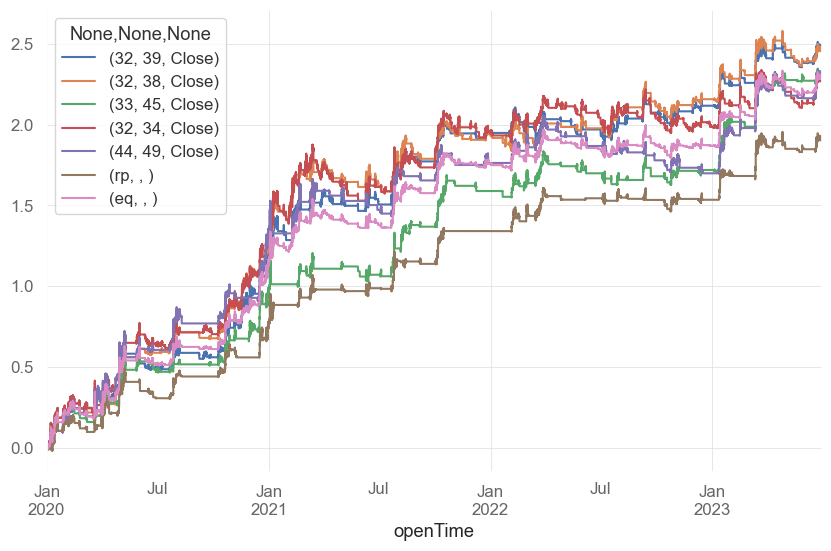

In [15]:
rett = portfolio.returns()

n = 72 * 6
rolling_risk = rett.rolling(n).std()
w_df_ = ((1/rolling_risk).T/(1/rolling_risk).sum(axis = 1)).T

rett['rp'] = (rett * w_df_).sum(axis=1)

rett['eq'] = rett.iloc[:, :10].mean(axis = 1) 

rett.cumsum().plot()

df_metrics = pd.DataFrame()
for col in rett.columns:
    df_metrics[col] = qs.reports.metrics(rett[col], mode='full', display=False, periods_per_year =4 * 24 * 365)

df_metrics.head(50)

<Axes: title={'center': 'Cumsum'}, xlabel='openTime'>

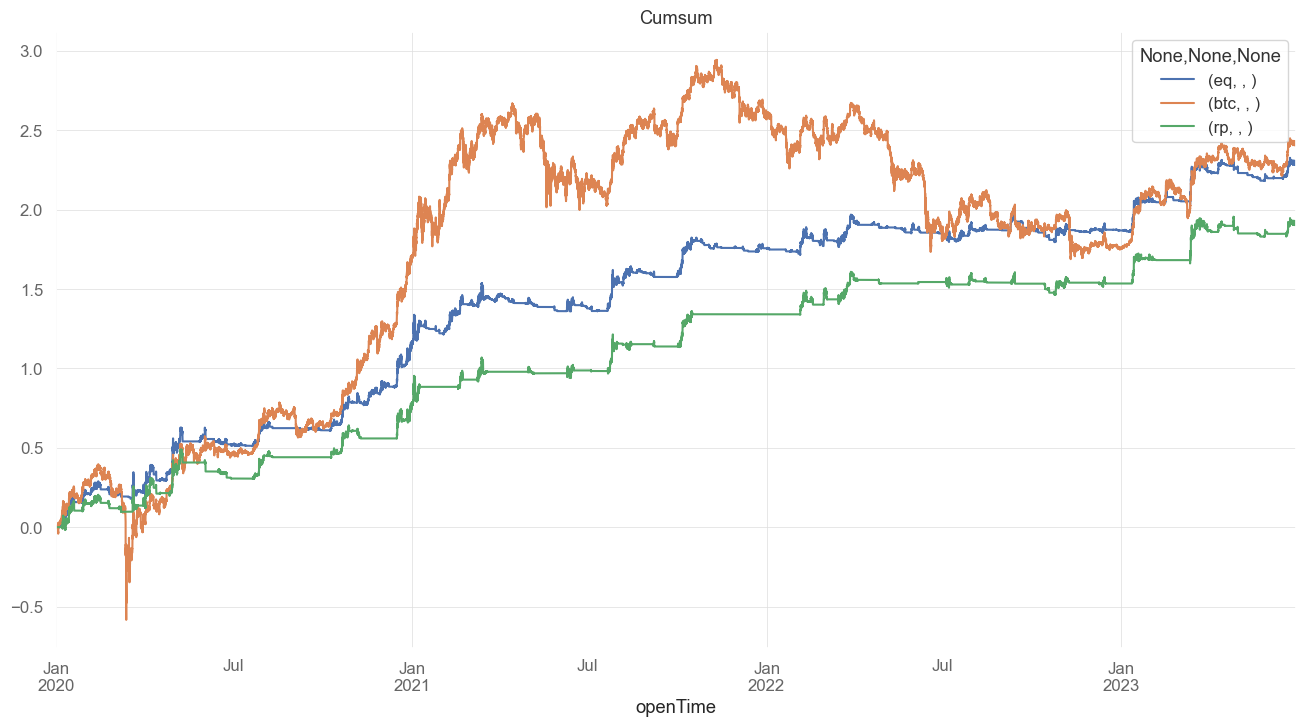

In [16]:
from datetime import datetime

rett['btc'] = df['Close'].pct_change()
fig, ax = plt.subplots(figsize=(16,8))
rett[['eq', 'btc', 'rp']].cumsum().plot(ax=ax, title = 'Cumsum')

In [27]:
qs_metrics = pd.DataFrame()

qs_metrics["benchmark"] = qs.reports.metrics(rett['btc'], mode='full', display=False, periods_per_year =4 * 24 * 365, compounded=False)
qs_metrics["eq_in_sample"] = qs.reports.metrics(rett['eq']['2020-01-01':'2022-08-31'], mode='full', display=False, periods_per_year =4 * 24 * 365, compounded = False)
qs_metrics["eq_out_sample"] = qs.reports.metrics(rett['eq']['2022-09-01':'2023-06-30'], mode='full', display=False, periods_per_year =4 * 24 * 365, compounded = False)
qs_metrics["eq_all"] = qs.reports.metrics(rett['eq'], mode='full', display=False, periods_per_year =4 * 24 * 365, compounded = False)
qs_metrics["rp_in_sample"] = qs.reports.metrics(rett['rp']['2020-01-01':'2022-08-31'], mode='full', display=False, periods_per_year =4 * 24 * 365, compounded = False)
qs_metrics["rp_out_sample"] = qs.reports.metrics(rett['rp']['2022-09-01':'2023-06-30'], mode='full', display=False, periods_per_year =4 * 24 * 365, compounded = False)
qs_metrics["rp_all"] = qs.reports.metrics(rett['rp'], mode='full', display=False, periods_per_year =4 * 24 * 365, compounded = False)


In [28]:
qs_metrics.head(60)
#qs_metrics.to_csv('metrics.csv')

,benchmark,eq_in_sample,eq_out_sample,eq_all,rp_in_sample,rp_out_sample,rp_all
Start Period,2020-01-01,2020-01-01,2022-09-01,2020-01-01,2020-01-01,2022-09-01,2020-01-01
End Period,2023-06-30,2022-08-31,2023-06-30,2023-06-30,2022-08-31,2023-06-30,2023-06-30
Risk-Free Rate,0,0,0,0,0,0,0
Time in Market,1.0,0.48,0.51,0.49,0.26,0.32,0.27
Total Return,2.42,1.87,0.43,2.3,1.54,0.38,1.92
CAGR﹪,0.28,0.31,0.35,0.27,0.27,0.31,0.24
Sharpe,0.93,2.1,1.88,2.05,1.95,1.75,1.91
Prob. Sharpe Ratio,0.96,1.0,0.96,1.0,1.0,0.94,1.0
Smart Sharpe,0.92,2.09,1.77,2.04,1.95,1.64,1.89
Sortino,1.32,3.0,2.71,2.93,2.78,2.53,2.73


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-01-03   2020-01-03
End Period                 2023-06-30   2023-06-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       49.0%

Cumulative Return          333.6%       730.95%
CAGR﹪                     33.7%        52.07%

Sharpe                     0.93         2.05
Prob. Sharpe Ratio         96.01%       99.99%
Smart Sharpe               0.93         2.04
Sortino                    1.33         2.93
Smart Sortino              1.33         2.92
Sortino/√2                 0.94         2.07
Smart Sortino/√2           0.94         2.06
Omega                      1.06         1.06

Max Drawdown               -77.27%      -18.49%
Longest DD Days            597          168
Volatility (ann.)          74.85%       32.04%
R^2                        0.28         0.28
Information Ratio          -0.0         -0.0
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-09-13,2022-10-24,2023-01-13,123,-18.489738,-17.888808
2,2021-03-13,2021-07-10,2021-07-26,135,-17.027300,-16.891572
3,2022-03-28,2022-07-07,2022-09-12,168,-16.111033,-15.582249
4,2021-01-03,2021-01-06,2021-02-09,37,-15.164823,-14.636149
5,2023-04-26,2023-05-28,2023-06-30,65,-14.392467,-14.237723


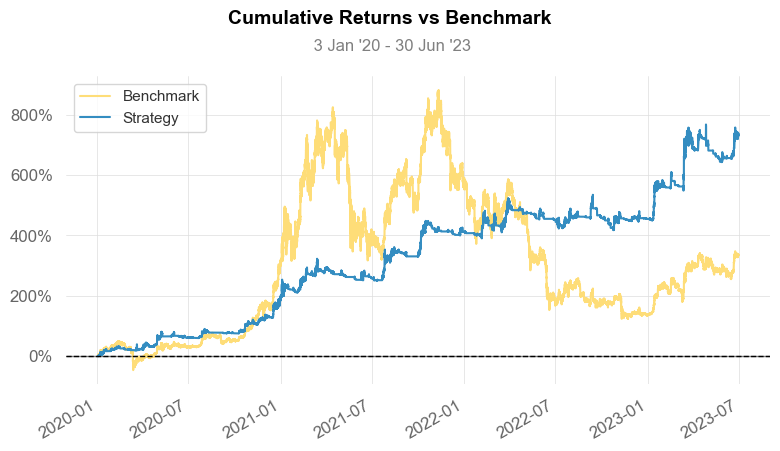

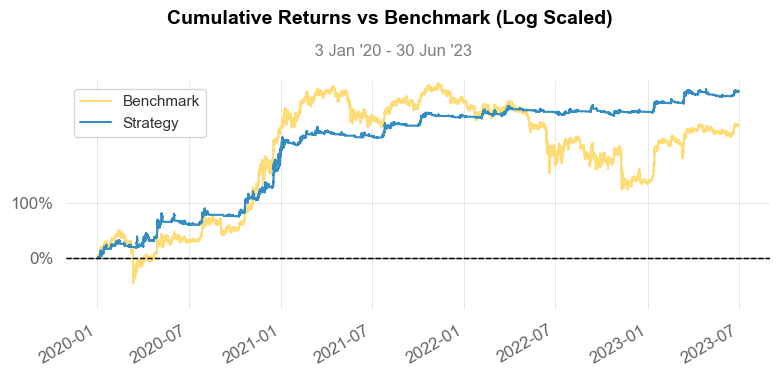

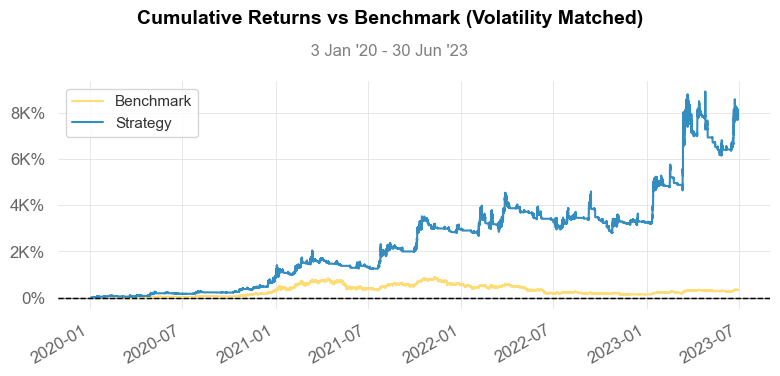

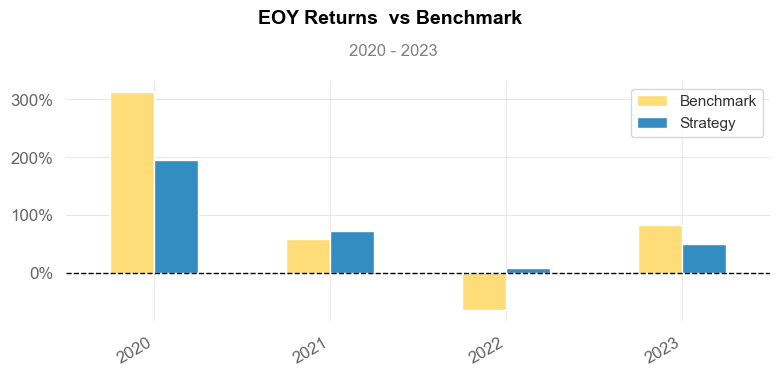

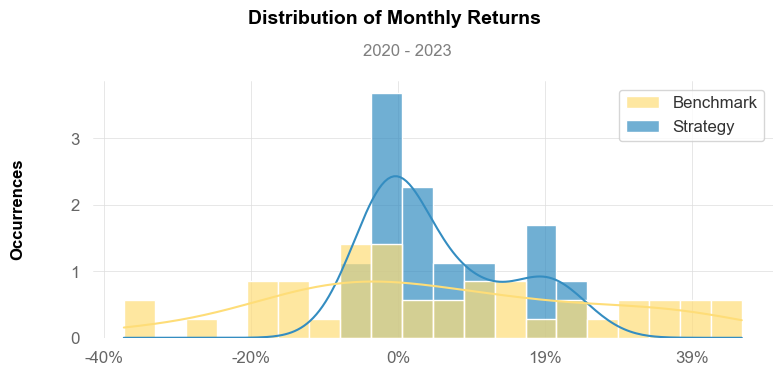

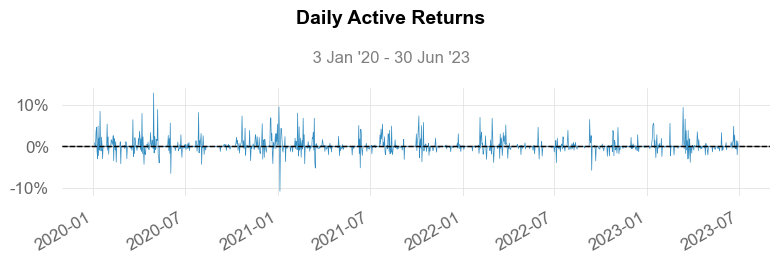

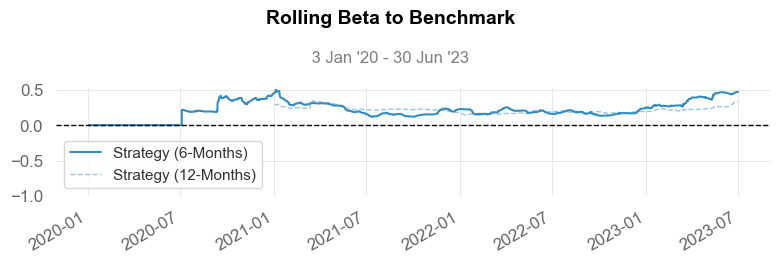

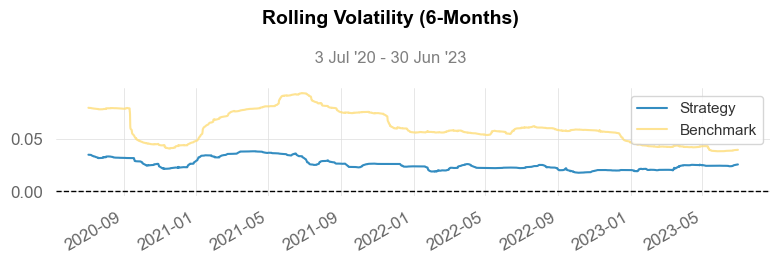

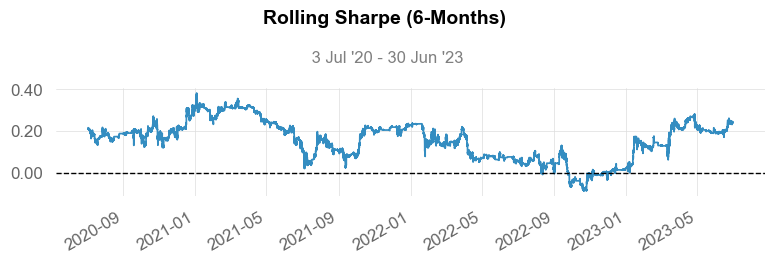

KeyboardInterrupt: 

In [26]:
qs.reports.full(rett['eq'], benchmark = rett['btc'], periods_per_year= 4 * 24 *365, compounded=True)